# Single Neuron Experiments

This tutorial introduces [Norse](norse.ai) and the concept of spiking neurons.
In the next 5-10 minutes or so you will learn about

- Spiking Neuron Models
- Gradient based learning with Spiking Neurons

## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [10]:
!pip install norse

import torch
import norse
import numpy as np
import matplotlib as mpl

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False

## Step 1: A simple neuron model

The point neuron models supported by Norse are almost all variants of the Leaky-Integrate and Fire neuron model. It is however relatively easy to implement your own model. The library
is build in layers, here I show an example of how to use the functional API directly. To
build large scale machine learning models, you should check out the tutorial on [PyTorch
lightning + Norse](high-performance-computing.ipynb).


In [11]:
from norse.torch.functional.lif import lif_step, LIFParameters, LIFState

class Neurons(torch.nn.Module):
    def __init__(self, weights, alpha):
        super(Neurons, self).__init__()
        self.hidden_size = hidden_size
        self.w_in = torch.nn.Parameter(torch.tensor(weights).float())
        self.w_rec = torch.zeros(hidden_size, hidden_size) # no recurrent connections
        
        self.lambda_vs = []
        self.lambda_is = []
        self.p = LIFParameters(alpha=alpha)

    def reset_lambda_recording(self):
        self.lambda_vs = []
        self.lambda_is = []

    def forward(self, z_in):
        seq_length, batch_size, _ = z_in.shape
        hidden_size = self.hidden_size

        s = LIFState(
            v = torch.zeros(batch_size, hidden_size, requires_grad=True),
            i = torch.zeros(batch_size, hidden_size, requires_grad=True),
            z = torch.zeros(batch_size, hidden_size)
        )
        voltages = torch.zeros(seq_length, batch_size, hidden_size)
        currents = torch.zeros(seq_length, batch_size, hidden_size)
        z_s = torch.zeros(seq_length, batch_size, hidden_size)

        def save_lambda_v(grad):
            if grad is not None:
                self.lambda_vs.append(grad)

        def save_lambda_i(grad):
            if grad is not None:
                self.lambda_is.append(grad)

        for ts in range(seq_length):
            z, s = lif_step(z_in[ts], s, self.w_in, self.w_rec, p=self.p)

            # record the gradient in the backward pass
            s.v.register_hook(save_lambda_v)
            s.i.register_hook(save_lambda_i)

            # save the voltage + synaptic input current state
            voltages[ts,:] = s.v
            currents[ts, :] = s.i
            z_s[ts,:] = z

        return z_s, voltages, currents

## Step 2.1: Optimizing for a fixed number of spikes

A simple task to consider is a single neuron stimulated at different times by $k$ fixed poisson distributed spike trains, with synaptic weights distributed according to a gaussian distribution. The goal is for the neuron to respond to these fixed spike trains with a certain number of spikes $n_\text{target}$ within a time $T$. The loss in this case is
$$
l = -n_\text{target}/T + \sum_i \delta(t - t_i) 
$$
so
$$
S = \int_0^T (-n_\text{target}/T + \sum_i \delta(t - t_i)) dt = n_\text{actual} - n_\text{target}
$$

In [17]:
from tqdm.notebook import trange

def run_training(
    w_in,
    z_in,
    alpha=100.0,
    max_epochs=100,
    target_spikes=6,
    target_spike_offset=10
):
    neurons = Neurons(w_in, alpha=torch.tensor(alpha))
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []

    pbar = trange(max_epochs)
    for e in pbar:
        optim.zero_grad()
        z_s, voltages, currents = neurons(z_in)

        # compute the loss according to the formula above
        loss = torch.sum(torch.abs((torch.sum(z_s, axis=0) - target_spikes)))
        loss.backward()

        pbar.set_postfix({"spike difference": loss.detach().item()})

        # keep track of the experiment data
        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)     
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))
        neurons.reset_lambda_recording()

        if loss.data == torch.tensor([0.0]):
            break

        # do a gradient optimisation step
        optim.step()

    return spikes_out, vs, cs, lambda_vs, lambda_is

In [18]:
seq_length = 1000
input_size = 20
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0

spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
w_in = np.random.randn(hidden_size,input_size) * np.sqrt(2/hidden_size)
spikes, vs, cs, lambda_vs, lambda_is = run_training(z_in=z_in, w_in=w_in, alpha=alpha, target_spikes=6, max_epochs=epochs)

Don't worry that the progress bar turned red, in this case it means that the optimisation
finished early. We can plot the error signals that are propagated backwards in time as follows. At each spike that reaches the neuron at synapse the variable $\lambda_i$ is accumulated to the gradient
of the synaptic weight.

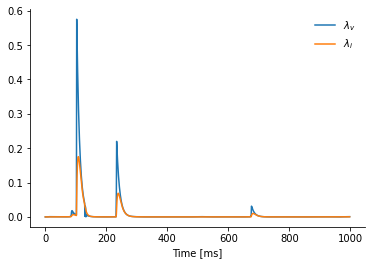

In [19]:
import matplotlib.pyplot as plt

epoch_from_last = 2
plt.plot(lambda_vs[-epoch_from_last][:,0], label='$\lambda_v$')
plt.plot(lambda_is[-epoch_from_last][:,0], label='$\lambda_i$')
plt.xlabel('Time [ms]')
plt.legend()

Exercises:
- Change the epoch_from_last variable to plot the error traces at different times in the optimisation
  procedure.
- Change the value alpha. What do you observe?
- Repeat the experiment with more biologically realistic parameters


In [20]:
norse.torch.functional.lif.LIFParameters?

Init signature:
norse.torch.functional.lif.LIFParameters(
    tau_syn_inv: torch.Tensor = tensor(200.),
    tau_mem_inv: torch.Tensor = tensor(100.),
    v_leak: torch.Tensor = tensor(0.),
    v_th: torch.Tensor = tensor(1.),
    v_reset: torch.Tensor = tensor(0.),
    method: str = 'super',
    alpha: float = tensor(100.),
)
Docstring:     
Parametrization of a LIF neuron

Parameters:
    tau_syn_inv (torch.Tensor): inverse synaptic time
                                constant (:math:`1/\tau_\text{syn}`) in 1/ms
    tau_mem_inv (torch.Tensor): inverse membrane time
                                constant (:math:`1/\tau_\text{mem}`) in 1/ms
    v_leak (torch.Tensor): leak potential in mV
    v_th (torch.Tensor): threshold potential in mV
    v_reset (torch.Tensor): reset potential in mV
    method (str): method to determine the spike threshold
                  (relevant for surrogate gradients)
    alpha (float): hyper parameter to use in surrogate gradient computation
File:        

## Step 2.2: Learning target spike times

Another task is for one neuron to spike at specific spike times $t_0, \ldots, t_N$ given that it stimulated 
by a fixed set of poisson distributed spikes. We can choose as a loss in this case
$$
l = \sum_i \lvert v - v_{\text{th}} \rvert^2 \delta(t - t_i) + l_N
$$
that is we require the membrane voltages to be close to the threshold $v_{th}$ at the required spike times $t_i$
and penalise the neuron if it spikes more or less than the required number of times.

In [42]:
from tqdm.notebook import trange

def run_target_spike_time_training(
    w_in,
    z_in,
    alpha=100.0,
    epochs=4000,
    target_times=[100, 300, 500, 700]
):
    neurons = Neurons(w_in, alpha=torch.tensor(alpha))
    optim = torch.optim.SGD(neurons.parameters(), lr=0.1)

    lambda_vs = []
    lambda_is = []
    spikes_out = []
    vs = []
    cs = []
    

    v_target = torch.zeros(seq_length, batch_size, hidden_size)
    target_spikes = len(target_times)

    for time in target_times:  
        v_target[time,:] = 1.1 * torch.ones(hidden_size)
    
    pbar = trange(epochs)
    for e in pbar:
        optim.zero_grad()

        z_s, voltages, currents = neurons(z_in)
        loss = torch.zeros(1,1)
        for time in target_times:    
            loss += 1/2 * 1/10 * (voltages[time,:] - v_target[time,:])**2

        dspikes = torch.sum(torch.abs(torch.sum(z_s, axis=0) - target_spikes))
        loss += dspikes
        loss.backward()

        pbar.set_postfix({"loss": loss.detach().item(), "spike difference": dspikes.detach().item()})

        vs.append(voltages.detach().data)
        cs.append(currents.detach().data)
        spikes_out.append(z_s.detach().data)
        lambda_vs.append(torch.stack(neurons.lambda_vs))
        lambda_is.append(torch.stack(neurons.lambda_is))

        neurons.lambda_vs = []
        neurons.lambda_is = []
        if loss.data == torch.tensor([0.0]):
            break

        optim.step()

    return spikes_out, vs, vs, lambda_vs, lambda_is

In [22]:
seq_length = 1000
input_size = 50
hidden_size = 1
batch_size = 1
epochs = 100
alpha = 100.0
target_times = [100, 300, 500, 700]


w_in = np.random.randn(hidden_size,input_size)* np.sqrt(2/hidden_size)
spikes = torch.distributions.bernoulli.Bernoulli(probs=0.04*torch.ones(seq_length, batch_size, input_size))
z_in = spikes.sample()
result = run_target_spike_time_training(w_in=w_in, z_in=z_in, alpha=alpha, epochs=epochs, target_times=target_times)

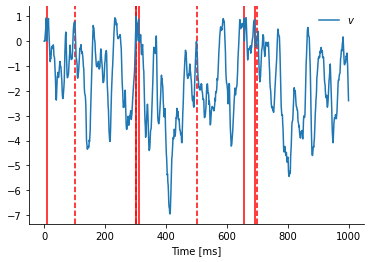

In [41]:
spikes, vs, cs, lambda_vs, lambda_is = result

actual_times = spikes[-1][:,0,0].to_sparse().indices()[0]


for ts in target_times:
    plt.axvline(x=ts, color='red', linestyle='--')

for ts in list(actual_times):
    plt.axvline(x=ts, color='red', linestyle='-')

plt.plot(vs[-1][:,0], label='$v$')
plt.xlabel('Time [ms]')
plt.legend()

We again visualise the error traces over time.

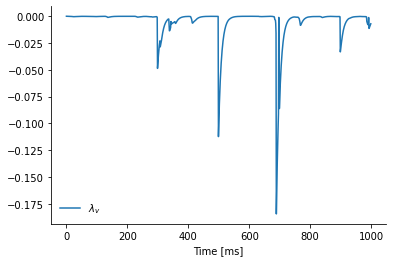

In [24]:
plt.plot(lambda_vs[-2][:,0], label='$\lambda_v$')
plt.xlabel('Time [ms]')
plt.legend()

Exercises:
- Add spike markers to the plot above (Optional and not )